# Generalized hourglass plots for MAF

## Setup of the notebook

### Imports

In [1]:
import warnings
import logging
import urllib
from os import path
from collections import OrderedDict
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from scipy.constants import golden

from rubin_sim import maf
import rubin_sim.maf.db
import rubin_sim.maf.metric_bundles
from rubin_sim.data import get_baseline

In [2]:
%matplotlib inline
# %config InlineBackend.figure_format = 'svg'
# %load_ext lab_black
# %load_ext pycodestyle_magic
# %flake8_on --ignore E501,W505
%load_ext autoreload
%autoreload 1

### `jupyter` magic

### Logging

Include logging to get a better idea of how long things take. This is more accurate than jupyter `%%time` magic, because it `%%time` does not include the time it takes for the client to render the plot, but this time is part of what is experienced by the user.

In [3]:
logging.basicConfig(format="%(asctime)s %(message)s")
logger = logging.getLogger("hourglass_notebook")
logger.setLevel("DEBUG")
logger.info("Starting")

2022-11-28 14:51:48,244 Starting


### Plotting configuration

The limited default resolution of matplotlib images can distort the gaps between exposures. This can be fixed either by increasing the precision of PNG image, or using a vector based format like SVG.
Comment out whichever jupyter magic below corresponds to the method you don't want to use.
For plots with lots of data, SVGs can cause performance issues in some browsers.

If you want to use SVGs, the line in this cell should be uncommented out:

In [4]:
# %config InlineBackend.figure_formats = ['svg']

If you want to use PNGs with high enough dpi to avoid pixel-level distortion, the lines in this cell can be uncommented out:

In [5]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

In [6]:
plt.rcParams["backend"]

'module://matplotlib_inline.backend_inline'

Note that increasing the pdi in a jupyter notebook will make the images very large when displayed within the notebook.

### Suppress useless warnings

In [7]:
warnings.filterwarnings(
    "ignore",
    append=True,
    message=r".*Tried to get polar motions for times after IERS data is valid.*",
)
warnings.filterwarnings("ignore", append=True, message=r".*dubious year.*")

### Configuration

In [8]:
data_dir = "."

If you have a local copy of the scheduler output you want to use, set `opsim_origin` to its path.

In [9]:

maf_output_dir = path.join(data_dir, "maf_output")

## Download the data file if necessary

## Get input and output database connections

In [10]:
logger.debug("Configuring database connections")
results_db = maf.db.ResultsDb(out_dir=maf_output_dir)

baseline = get_baseline()

2022-11-28 14:51:48,376 Configuring database connections


## Samples

### Median Seeing in 5 minute time intervals

Use the `TimeIntervaleSlicer` to divide the survey into 300 second (5 minute) time segments, and calculate the median seeing in each segment.
Make an hourglass plot of the result for October of 2023.

2022-11-28 14:51:48,420 Starting hourglass


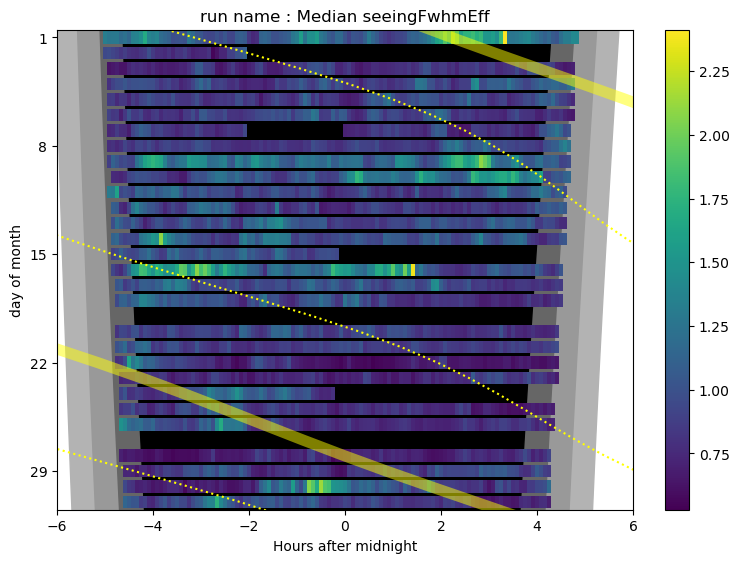

<Figure size 640x480 with 0 Axes>

In [11]:
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metric_bundles.MetricBundle(
            metric=maf.metrics.MedianMetric("seeingFwhmEff"),
            slicer=maf.slicers.TimeIntervalSlicer(interval_seconds=300),
            constraint="",
            plot_funcs=[maf.plots.MonthHourglassPlot(10, 2023)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db,
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [12]:
import numpy as np
np.array([]).__class__

numpy.ndarray

In [13]:
logger.info("Finished hourglass")

2022-11-28 14:53:24,736 Finished hourglass


### Hour Angle by visit

Use the `VisitIntervaleSlicer` to divide the survey into time segments each of which covers one visit, and calculate the hour angle in each segment.
Make an hourglass plot of the result for October of 2023.

Set the color map to be diverging, and force the color limits such that 0 (transiting) is gray, while positive and negative hour angle are red and blue.

2022-11-28 14:53:24,747 Starting hourglass


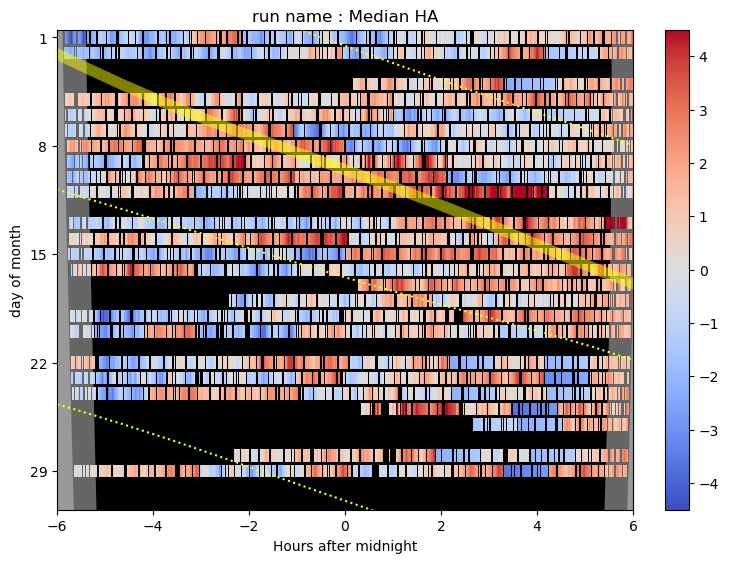

<Figure size 640x480 with 0 Axes>

In [14]:
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metric_bundles.MetricBundle(
            metric=maf.metrics.MedianMetric("HA"),
            slicer=maf.slicers.VisitIntervalSlicer(),
            constraint="",
            plot_dict={"cmap": plt.get_cmap("coolwarm"), "color_limits": (-4.5, 4.5)},
            plot_funcs=[maf.plots.MonthHourglassPlot(7, 2025)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [15]:
logger.info("Finished hourglass")

2022-11-28 14:55:47,954 Finished hourglass


### Filter metric

In [16]:
# This could have been the Pass metric instead .. (just returns the values in a given set of columns)
class FilterUseMetric(maf.metrics.BaseMetric):
    """Metric to classify visits by filter"""

    def __init__(self, filter_col="filter", **kwargs):
        self.filter_col = filter_col
        super().__init__(col=[filter_col], metric_dtype="object", **kwargs)

    def run(self, data_slice, slice_point=None):  # pylint: disable=invalid-name
        """Run the metric.

        Parameters
        ----------
        dataSlice : numpy.NDarray
           Values passed to metric by the slicer, which the metric will use to calculate
           metric values at each slicePoint.
        slicePoint : Dict
           Dictionary of slicePoint metadata passed to each metric.
           E.g. the ra/dec of the healpix pixel or opsim fieldId.

        Returns
        -------
        str
            use at each slicePoint.
        """
        return data_slice[self.filter_col]

2022-11-28 14:55:47,980 Starting hourglass


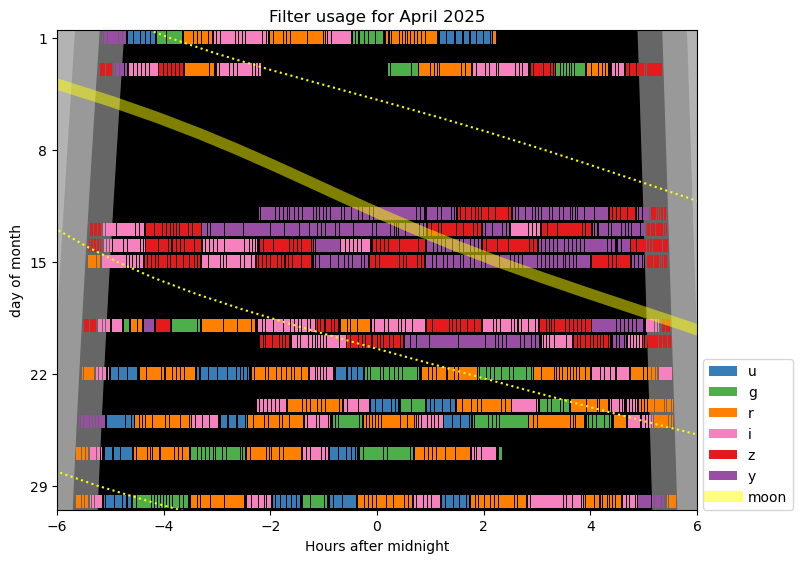

<Figure size 640x480 with 0 Axes>

In [17]:
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metric_bundles.MetricBundle(
            metric=FilterUseMetric(),
            slicer=maf.slicers.VisitIntervalSlicer(),
            constraint="night < 1200",
            plot_dict={
                "cmap": plt.get_cmap("Set1"),
                "assigned_colors": OrderedDict(
                    [("u", 1), ("g", 2), ("r", 4), ("i", 7), ("z", 0), ("y", 3)]
                ),
                "title": "Filter usage for April 2025",
                "legend_ncols": 1,
                "legend_loc": (1.01, 0.5),
                "legend_bbox_to_anchor": (1.01, 0.0),
                "legend": True,
            },
            plot_funcs=[maf.plots.MonthHourglassCategoricalPlot(4, 2025)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [18]:
logger.info("Finish hourglass")

2022-11-28 14:56:16,555 Finish hourglass


### Time use by sets of adjacent visits with common "note" values

"Note" values in the database indicate how the scheduler selected visits. Divide the survey into time intervals of consecutive visits with common notes, and assign color codes according to the filters and program indicated by the note. 

#### One month

2022-11-28 14:56:16,568 Starting hourglass


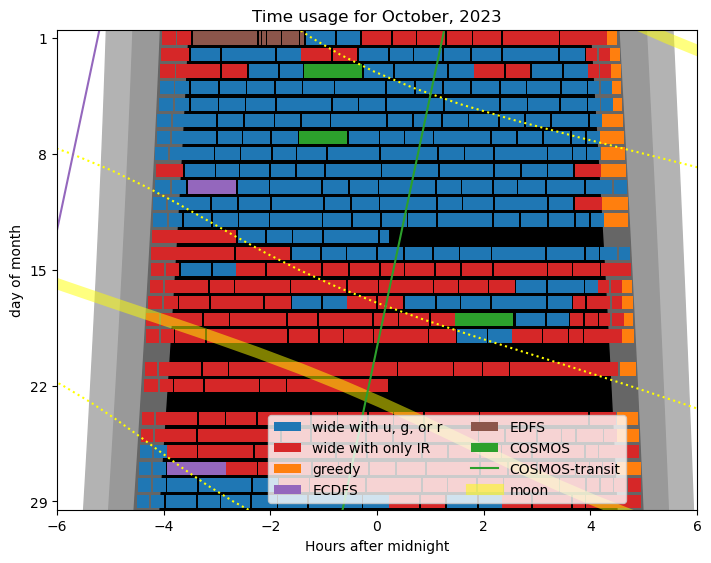

<Figure size 640x480 with 0 Axes>

In [19]:
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metricBundles.MetricBundle(
            metric=maf.metrics.UseMetric(),
            slicer=maf.slicers.BlockIntervalSlicer(),
            constraint="",
            plot_dict={
                "title": "Time usage for October, 2023",
                "legend_elements": (
                    "wide with u, g, or r",
                    "wide with only IR",
                    "greedy",
                    "ECDFS",
                    "EDFS",
                    "ELAISS1",
                    "COSMOS",
                    "COSMOS-transit",
                    "XMM-LSS",
                    "moon",
                ),
            },
            plot_funcs=[maf.plots.MonthHourglassUsePlot(2, 2024)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [20]:
logger.info("Finished hourglass")

2022-11-28 14:56:30,325 Finished hourglass


In this plot, the red represents scheduled "blobs" that include only exposures in IR (i, z, or y) filters, and the blue scheduled blobs with at least some exposures with filters covering shorter wavelengths. The orange shows times during which the "greedy" algorithm was used by the scheduler. Horizontal bars with other colors indicate times during which DDF fields were observed. The thick slanted yellow line shows the times of the transit of the moon, while the dotted yellow lines show moon rise and set. Slanted lines of other colors show  the transit times of each DDF field, with the same color coding as used for the bars that indicate when the DDFs are observed. The vertical axis indicates the day of the month on which the night starts, and the horizontal axis the time relative to local solar midnight (solar anti-transit). A white background indicates day time; black, full night; and different shades of gray, civil, nautical, and astronomical twilight.

If you wish to show the time relative to local civil midnight, you can pass the `solar_time=False` to the hourglass plotter:

2022-11-28 14:56:30,342 Starting hourglass


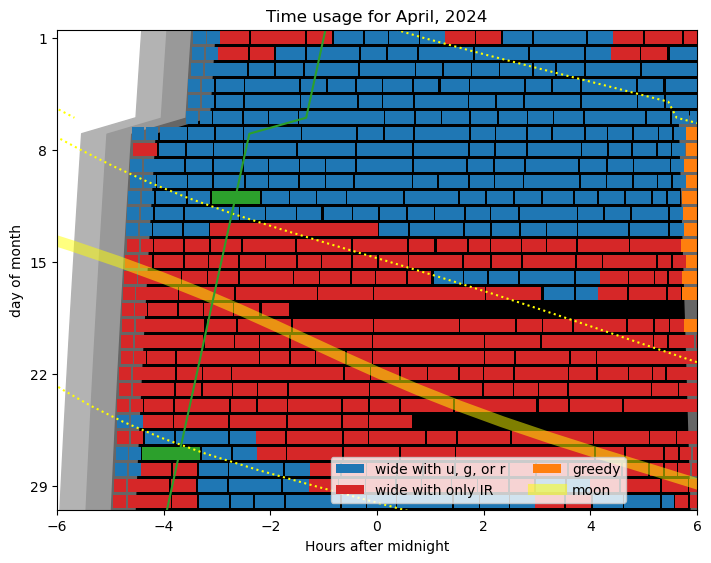

<Figure size 640x480 with 0 Axes>

In [21]:
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metric_bundles.MetricBundle(
            metric=maf.metrics.UseMetric(),
            slicer=maf.slicers.BlockIntervalSlicer(),
            constraint="",
            plot_dict={
                "title": "Time usage for April, 2024",
                "xMin": -6.5,
                "xMax": 8.5,
                "legend_elements": (
                    "wide with u, g, or r",
                    "wide with only IR",
                    "greedy",
                    "ECDFS",
                    "EDFS",
                    "COSMOS" "ELAISS1",
                    "XMM-LSS",
                    "moon",
                ),
            },
            plot_funcs=[maf.plots.MonthHourglassUsePlot(4, 2024, solar_time=False)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

Note the jump at the end of daylight savings time.

#### One Year

2022-11-28 14:56:44,397 Starting hourglass


CPU times: user 48.9 s, sys: 985 ms, total: 49.9 s
Wall time: 51.3 s


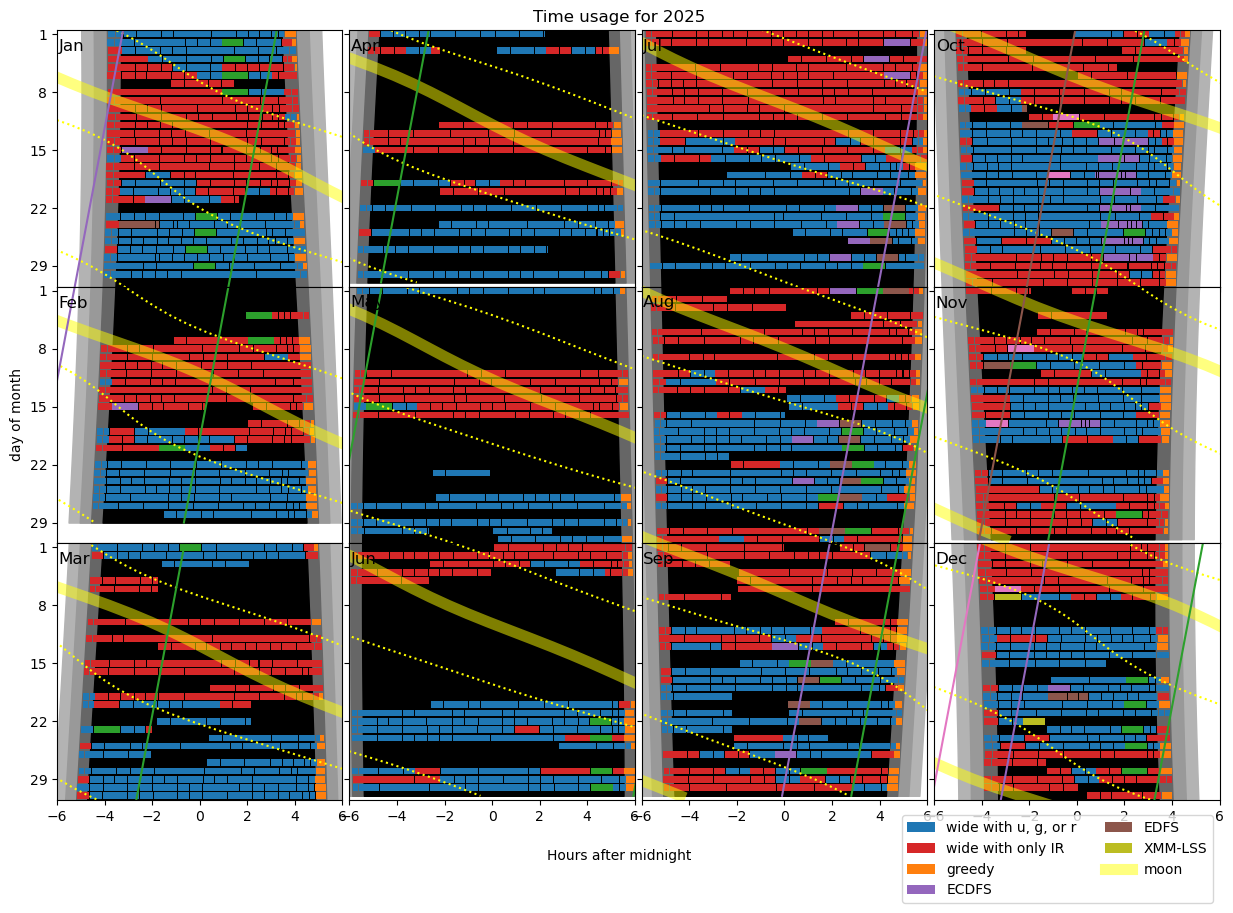

<Figure size 640x480 with 0 Axes>

In [22]:
%%time
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metric_bundles.MetricBundle(
            metric=maf.metrics.UseMetric(),
            slicer=maf.slicers.BlockIntervalSlicer(),
            constraint="",
            plot_dict={'figsize': (15, 10), 'title': "Time usage for 2025",
                      'legend_elements': ('wide with u, g, or r',
                                          'wide with only IR',
                                          'greedy',
                                          'ECDFS',
                                          'EDFS',
                                          'COSMOS'
                                          'ELAISS1',
                                          'XMM-LSS',
                                          'moon')},
            plot_funcs=[maf.plots.YearHourglassUsePlot(2025)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

#### Whole survey

Making plots for all years in the survey is slow, usually taking between 15 and 20 minutes on my test node.
This is done using separate instances of plotter objects, rather than just one, because the plot gets too compressed (or too big) otherwise.

2022-11-28 14:57:40,743 Starting hourglass


CPU times: user 7min 28s, sys: 4.61 s, total: 7min 33s
Wall time: 7min 41s


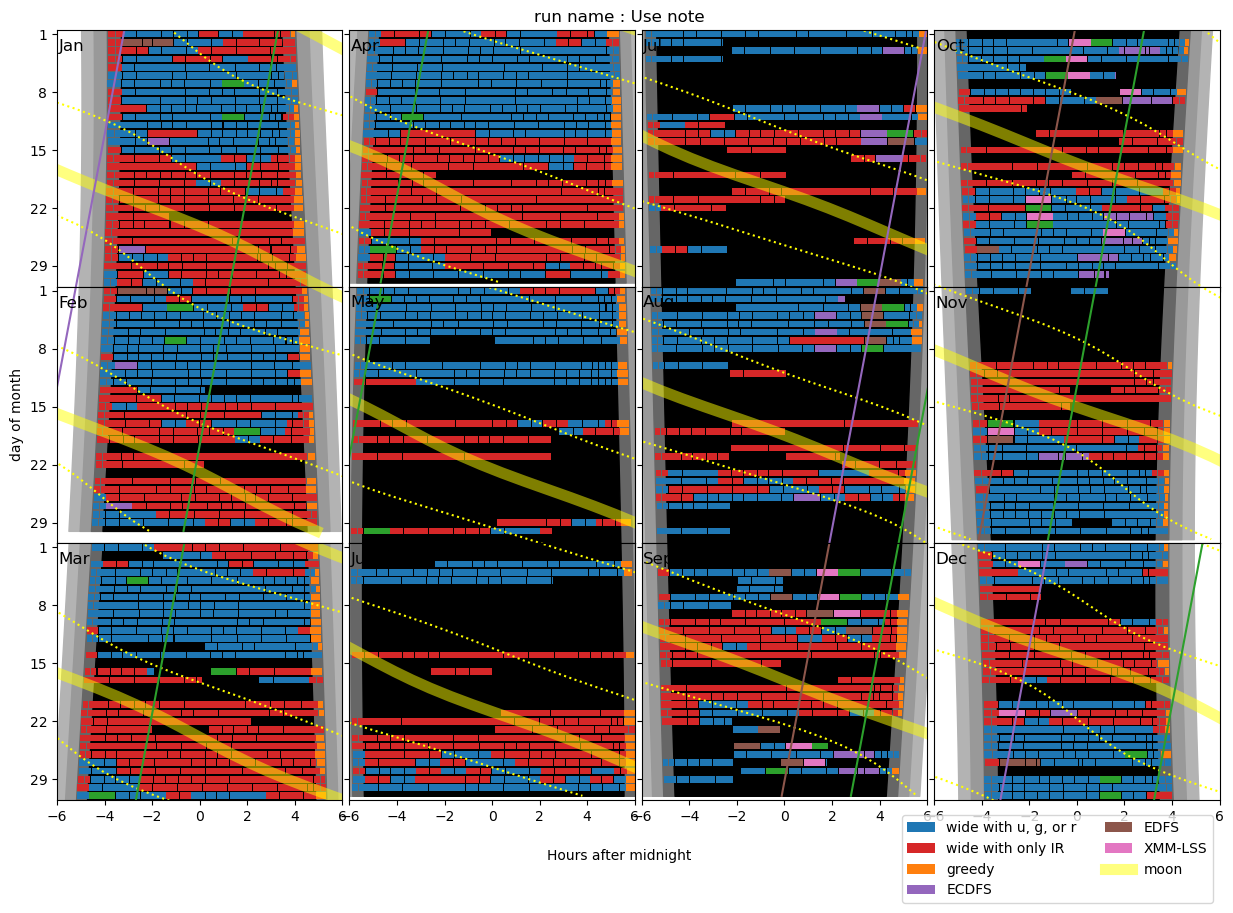

<Figure size 640x480 with 0 Axes>

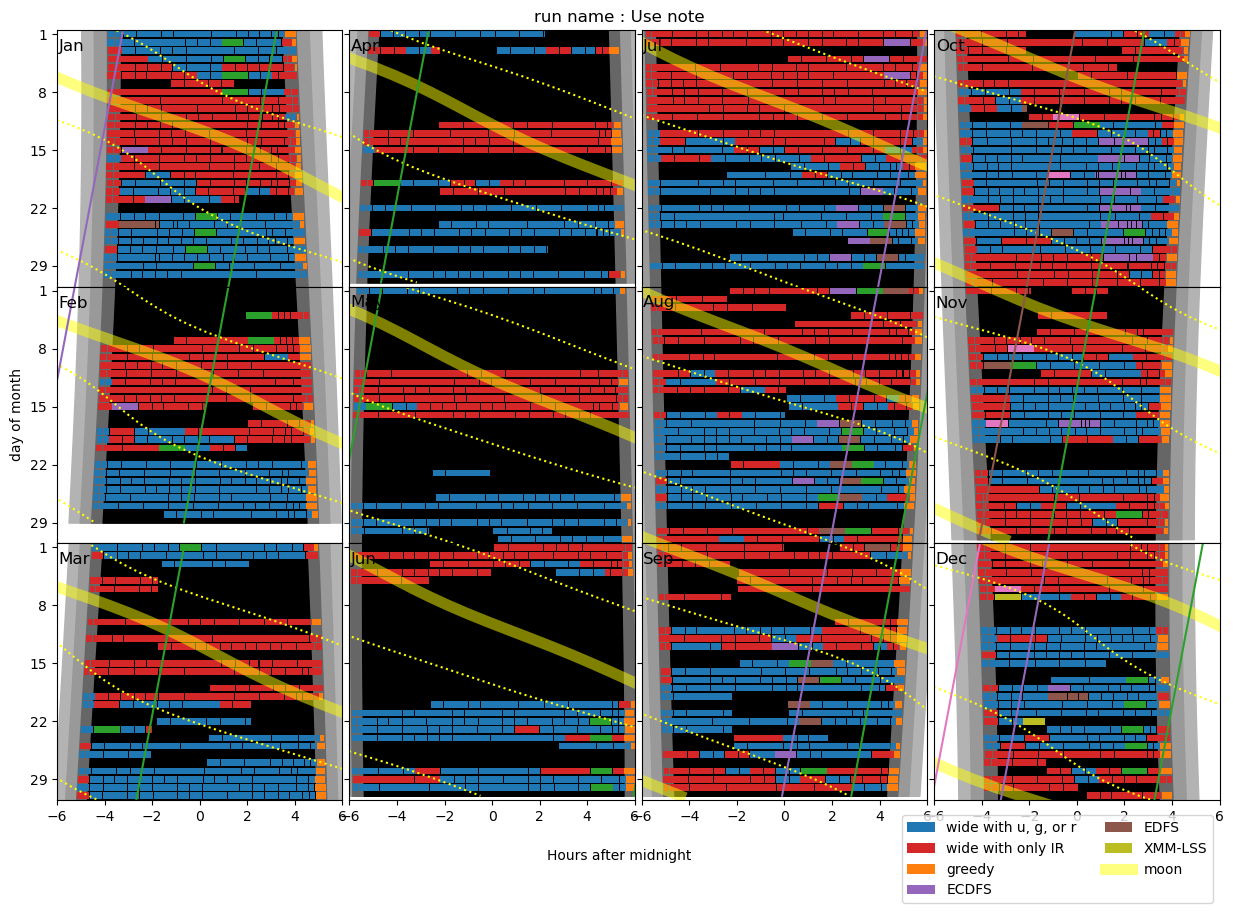

<Figure size 640x480 with 0 Axes>

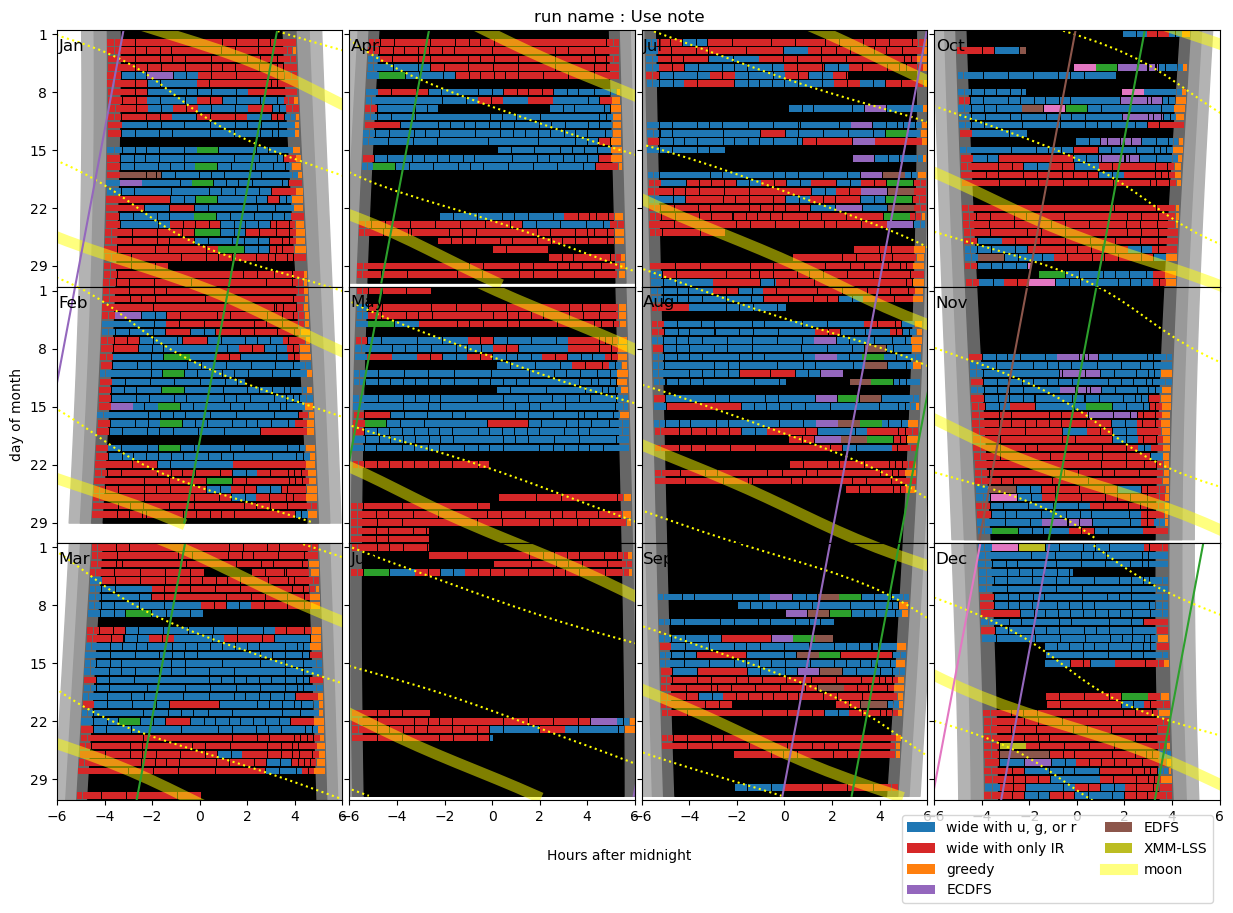

<Figure size 640x480 with 0 Axes>

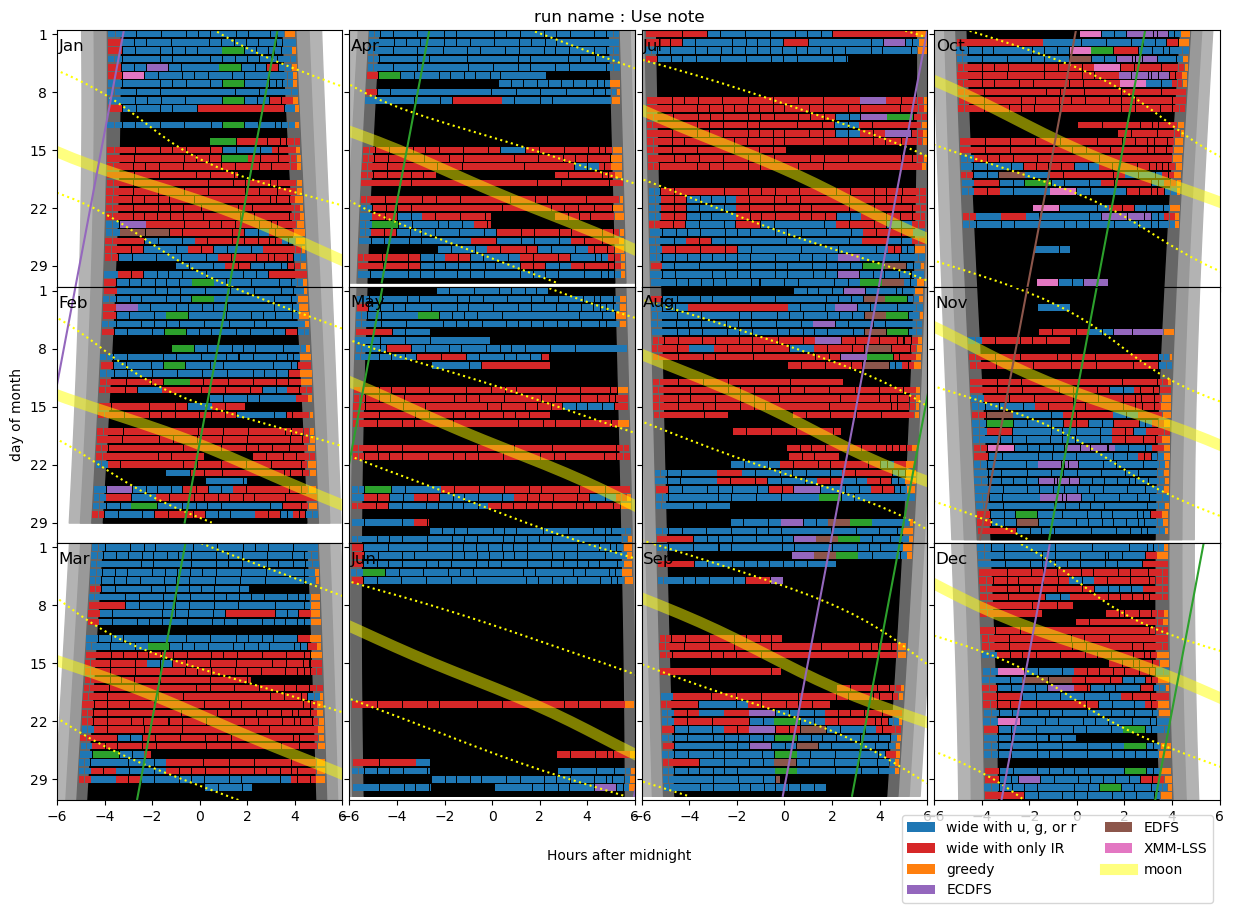

<Figure size 640x480 with 0 Axes>

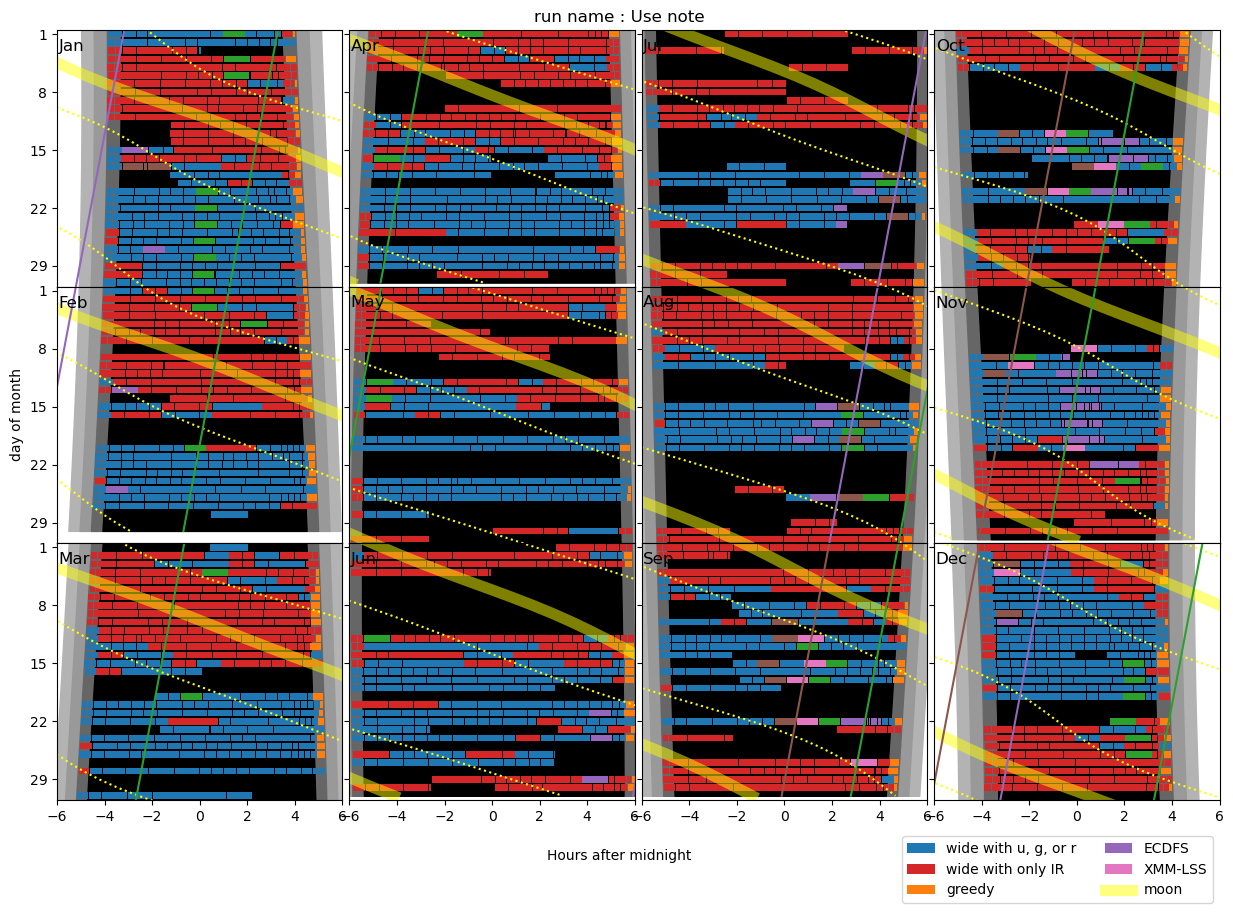

<Figure size 640x480 with 0 Axes>

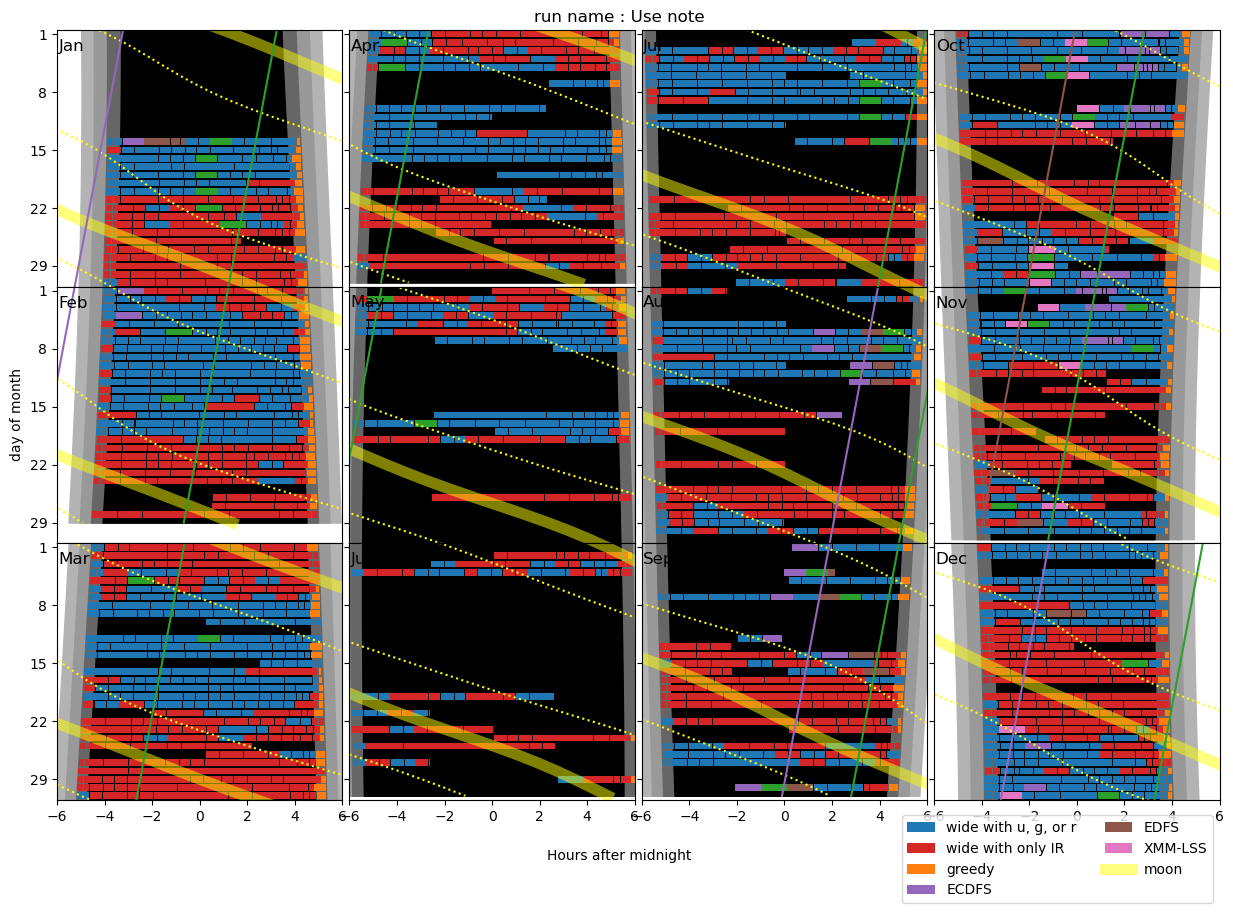

<Figure size 640x480 with 0 Axes>

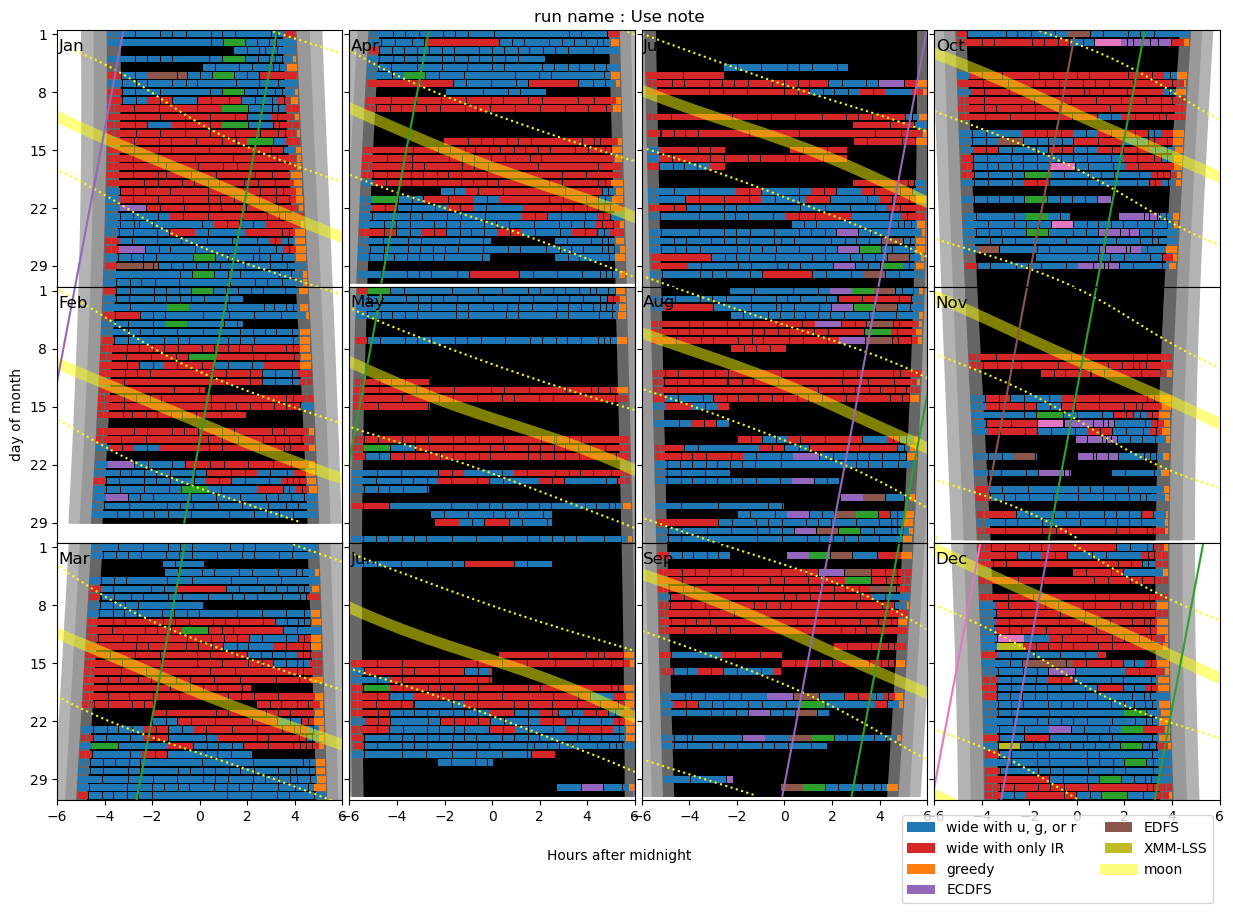

<Figure size 640x480 with 0 Axes>

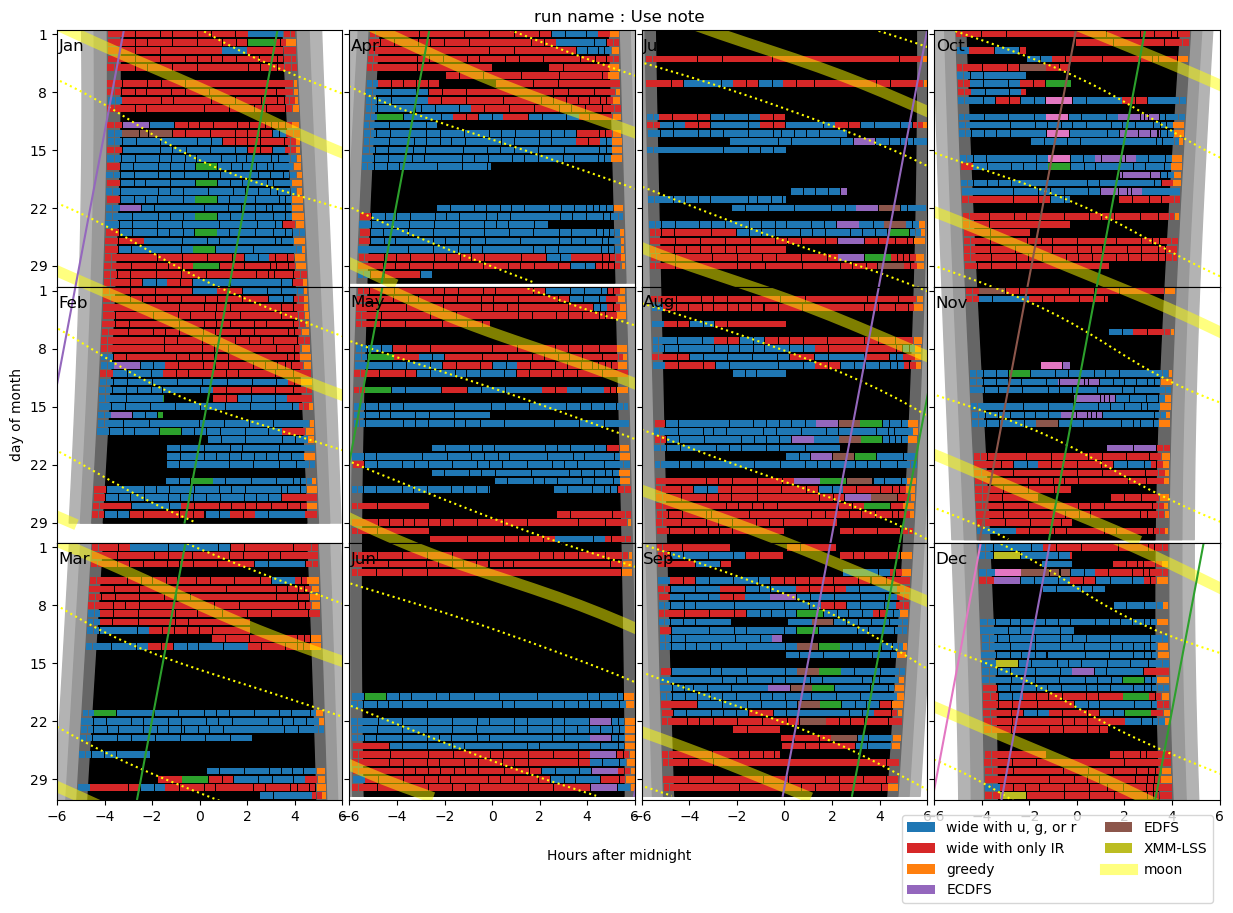

<Figure size 640x480 with 0 Axes>

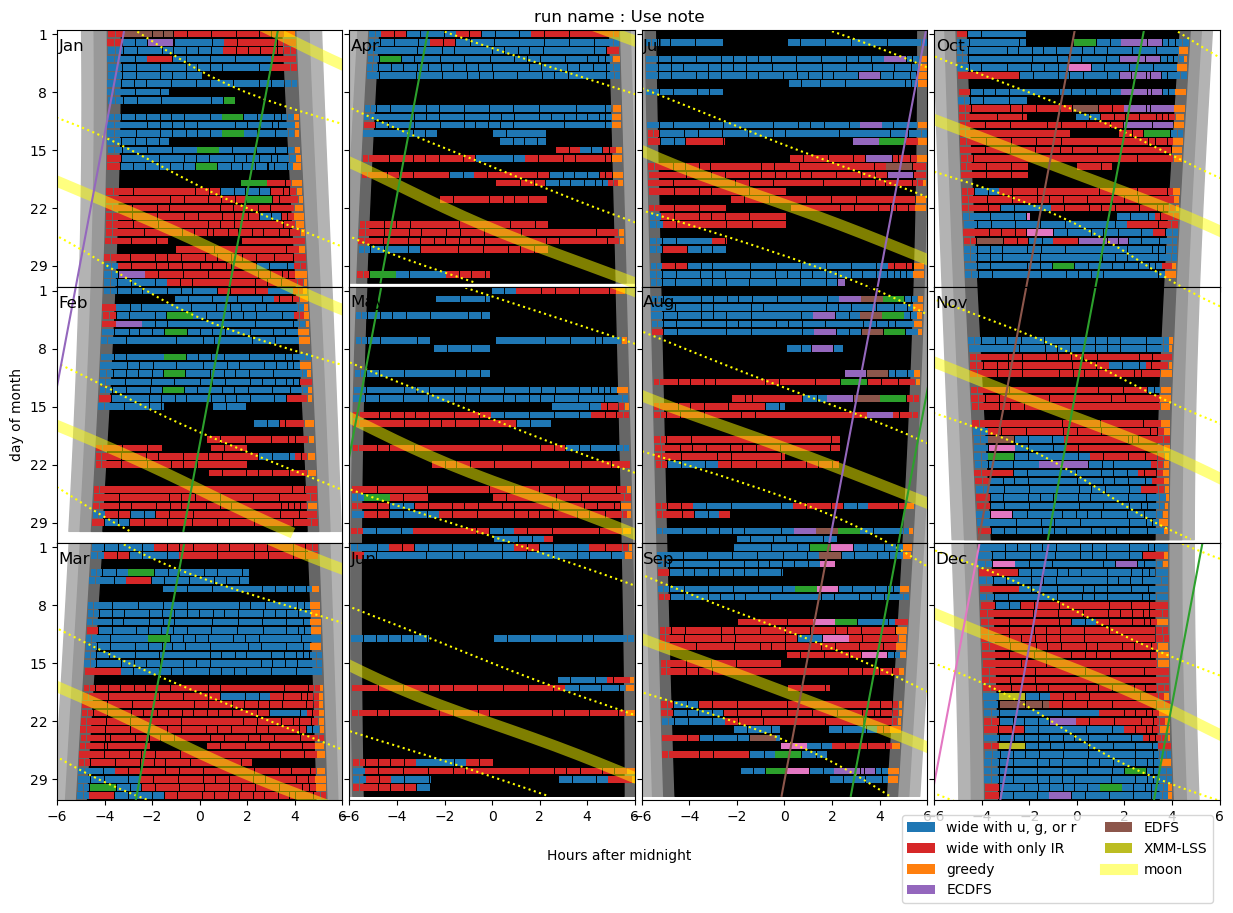

<Figure size 640x480 with 0 Axes>

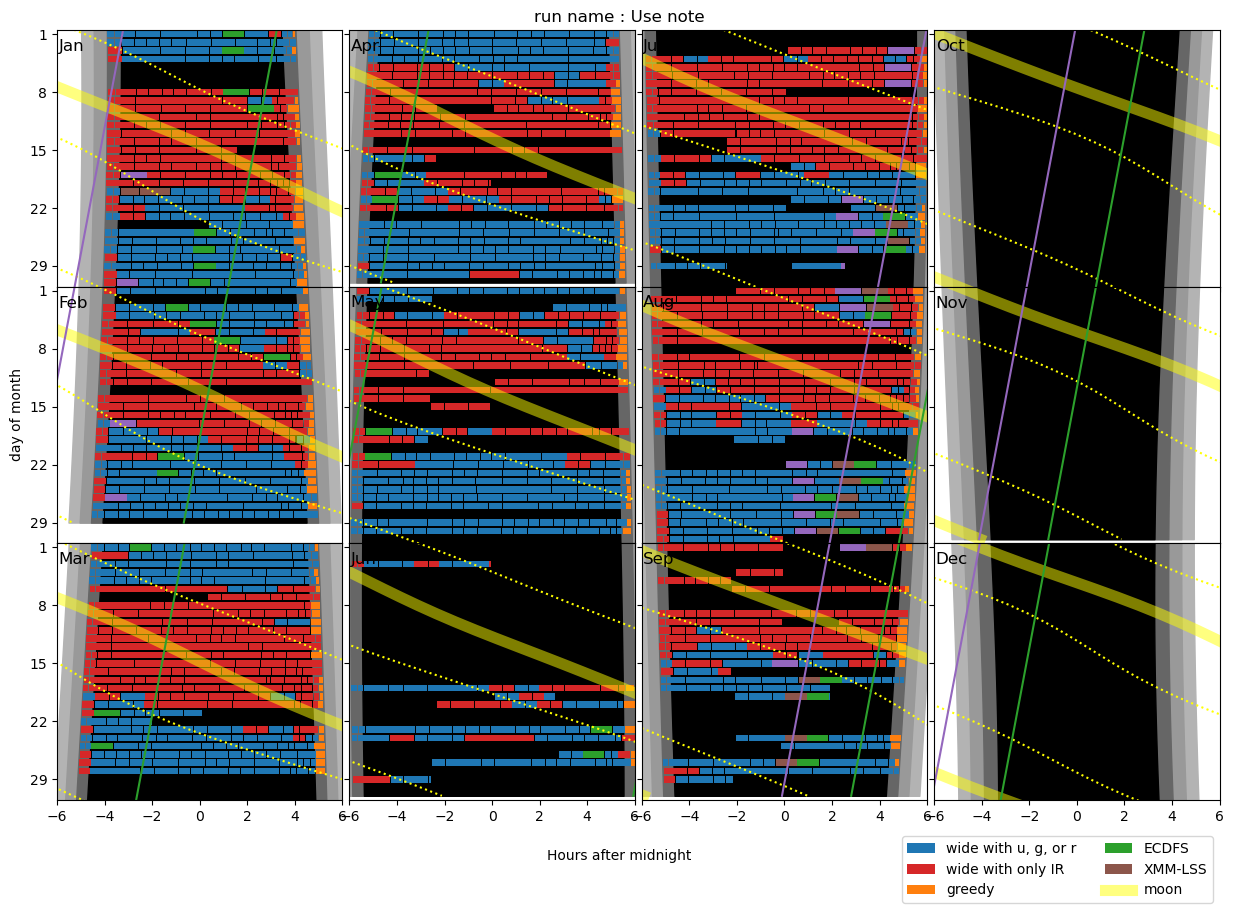

<Figure size 640x480 with 0 Axes>

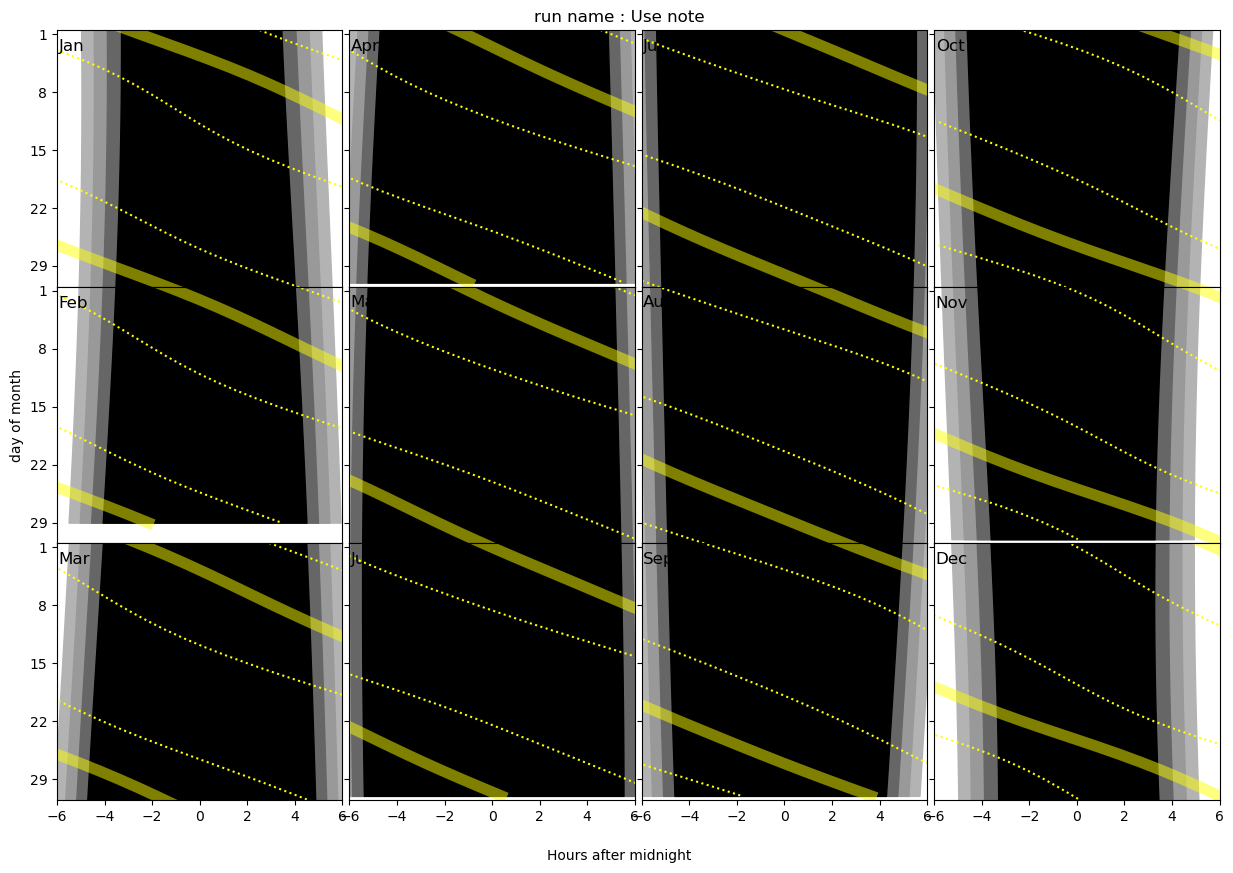

<Figure size 640x480 with 0 Axes>

In [23]:
%%time
logger.info("Starting hourglass")
bundle_group = maf.metric_bundles.MetricBundleGroup(
    bundle_dict=[
        maf.metric_bundles.MetricBundle(
            metric=maf.metrics.UseMetric(),
            slicer=maf.slicers.BlockIntervalSlicer(),
            constraint="",
            plot_dict={'figsize': (15, 10),
                      'legend_elements': ('wide with u, g, or r',
                                          'wide with only IR',
                                          'greedy',
                                          'ECDFS',
                                          'EDFS',
                                          'COSMOS'
                                          'ELAISS1',
                                          'XMM-LSS',
                                          'moon')},
            plot_funcs=[maf.plots.YearHourglassUsePlot(y) for y in range(2024, 2035)],
        )
    ],
    db_con=baseline,
    out_dir=maf_output_dir,
    results_db=results_db
)
bundle_group.run_all()
bundle_group.plot_all(closefigs=False)

In [24]:
logger.info("Finished hourglass")

2022-11-28 15:06:19,713 Finished hourglass
